<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab_commented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

# The number of sentences which have wrong labels
error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]


# Wrong label comparison
print(list(metadata[0, 3])) # Correct
print(list(metadata[error_jamos[0], 3])) # Wrong


# Delete wrong data and check the length
print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

# Fix the size of the dataset as a deleted metadata length
dataset_size = len(metadata)

['ᄀ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅫ', 'ᆫ', 'ᄎ', 'ᅡ', 'ᆭ', 'ᄋ', 'ᅳ', 'ᆫ', ' ', 'ᄎ', 'ᅥ', 'ᆨ', 'ᄒ', 'ᅡ', 'ᄅ', 'ᅧ', 'ᄀ', 'ᅩ', ' ', 'ᄋ', 'ᅢ', 'ᄊ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅥ', 'ᆺ', ' ', 'ᄀ', 'ᅡ', 'ᇀ', 'ᄋ', 'ᅡ', 'ᆻ', 'ᄃ', 'ᅡ', '.']
['인', '터', '넷', ' ', '서', '핑', ' ', '중', '이', '에', '요', '.']
(12853, 5)
(12833, 5)


In [3]:
character_length = list() # List of the length of labels
file_length = list() # List of the length of a wav file as sec.
division_length = list() # List of (length of a wav file / length of a label)

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = [] # List of wav file names

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list() 

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(ord('A'), ord('Z') + 1):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(ord('a'), ord('z') + 1):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(ord('0'), ord('9') + 1):
    unicode_jamo_list.append(chr(unicode))
    
    
unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', '?', '？', '/','%', '(', ')', ':', ';','+', '-', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

# Check the symbols
print(''.join(unicode_jamo_list))

print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

_ !%()+,-./0123456789:;<<eos>>?ABCDEFGHIJKLMNOPQRSTUVWXYZ\^abcdefghijklmnopqrstuvwxyz~ᄀᄁᄂᄃᄄᄅᄆᄇᄈᄉᄊᄋᄌᄍᄎᄏᄐᄑ하ᅢᅣᅤᅥᅦᅧᅨᅩᅪᅫᅬᅭᅮᅯᅰᅱᅲᅳᅴᅵᆨᆩᆪᆫᆬᆭᆮᆯᆰᆱᆲᆳᆴᆵᆶᆷᆸᆹᆺᆻᆼᆽᆾᆿᇀᇁᇂ？
['_', ' ', '!', '%', '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '<eos>', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', '？']
150


In [6]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [7]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [8]:
# Create mel-spectrogam images from wav files, 
# if mel-spectrogram file already exist, just add their names to the mel_path_list
 
mel_path_list = list()
wav_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    wav_path_list.append(wav_path)
    
#     # If you have already saved mel-spectrogram, skip mel creating process
#     if not os.path.isfile(mel_path):
        
#         y, sr = librosa.core.load(wav_path, sr=fs) # I made a mistake... sr=fs
#         f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
#         Sxx = np.abs(Zxx)
# #       Sxx = np.maximum(Sxx, eps)

#         # mel_filters: (n_fft, n_mels)
#         mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
#         mel_specgram = np.matmul(mel_filters, Sxx)

#         # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
#         log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
#         # 20 * log10(eps) = 20 * -8 = -160
#         # -160 is the smallest value
#         # Add 160 and divide by 160 => Normalize value between 0 and 1
#         norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

#         np.save(mel_path, norm_log_mel_specgram)

In [9]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [10]:
def bind_model(model, optimizer=None):
    def load(filename, **kwargs):
        state = torch.load(os.path.join(filename, 'model.pt'))
        model.load_state_dict(state['model'])
        if 'optimizer' in state and optimizer:
            optimizer.load_state_dict(state['optimizer'])
        print('Model loaded')

    def save(filename, **kwargs):
        state = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(state, os.path.join(filename, 'model.pt'))

    def infer(wav_path):
        model.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Implement here
        input_tensor = get_spectrogram_feature(wav_path).unsqueeze(0)
        input_tensor = input_tensor.to(device)

        logit = model(input_variable=input, input_lengths=None, teacher_forcing_ratio=0)
        logit = torch.stack(logit, dim=1).to(device)

        y_hat = logit.max(-1)[1]
        hyp = label_to_string(y_hat)

        return hyp[0]

    nsml.bind(save=save, load=load, infer=infer) # 'nsml.bind' function must be called at the end.

In [11]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor
        
           
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

net_optimizer = optim.Adam(net.parameters(), lr=0.001)

ctc_loss = nn.CTCLoss().to(device)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [13]:
class Threading_Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Threading_Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(32)
        self.thread_flags = list()
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.mel_path_list, self.ground_truth_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, mel_path_list, ground_truth_list, load_idxs_list, queue, batch_size, thread_flags, id):
        
        threading.Thread.__init__(self)
        self.mel_path_list = mel_path_list
        self.ground_truth_list = ground_truth_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 

    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
            
            mel_path = self.mel_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.load_mel(mel_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            # Time shift, add zeros in front of an image
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
            
            # Add random noise
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            # Value less than 0 or more than 1 is clamped to 0 and 1
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list]

    def load_mel(self, mel_path):
        norm_log_mel_specgram = np.load(mel_path)
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input

In [14]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [15]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_eval))

12833
12833
10266
10266
2567


In [16]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_eval = Threading_Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, 64)

preloader_train = Threading_Batched_Preloader(mel_path_list_train, ground_truth_list_train, 64)

In [17]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

Loading Failed
Loading Error
09-19 00:15:41
Mean Train Loss: 0.07738402579178641
Mean Evaluation Loss: 0.07417419398405828
-------------------------------------------------------------------------------------------------------
09-19 00:15:55
Mean Train Loss: 0.07604637994814574
Mean Evaluation Loss: 0.07652776369460068
-------------------------------------------------------------------------------------------------------
09-19 00:16:09
Mean Train Loss: 0.07601398861051567
Mean Evaluation Loss: 0.0656003381692355
-------------------------------------------------------------------------------------------------------
09-19 00:16:23
Mean Train Loss: 0.06712041529314784
Mean Evaluation Loss: 0.062324350867034584
-------------------------------------------------------------------------------------------------------
09-19 00:16:37
Mean Train Loss: 0.06659869110284954
Mean Evaluation Loss: 0.06681106638079595
-------------------------------------------------------------------------------------

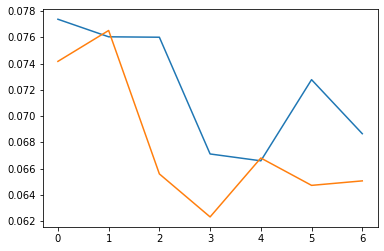

아_________으__아__아_ᄋ____아______ᄋ___아_아__아__아___ᅡ_____다________________________________________________________.<eos>
아으아아ᄋ아ᄋ아아아아ᅡ다.<eos>
선수들은 심판의 판정을 존중해야 한다.<eos>___________


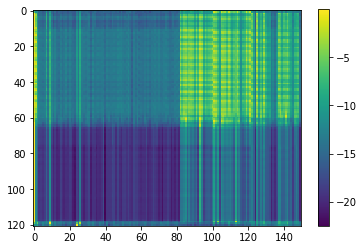

아_________아__아__아__아__아_____아__이__ᄋ__ᄋ____________________________ᅭ.<eos>
아아아아아아아이ᄋ요.<eos>
잠시 여기서 기다려 주십시오.<eos>_____


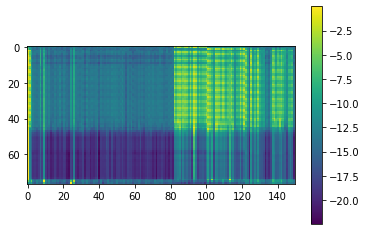

-------------------------------------------------------------------------------------------------------
09-19 00:17:20
Mean Train Loss: 0.07382434555445888
Mean Evaluation Loss: 0.07290722594956452
-------------------------------------------------------------------------------------------------------
09-19 00:17:35
Mean Train Loss: 0.07253364495075187
Mean Evaluation Loss: 0.060131594508310175
-------------------------------------------------------------------------------------------------------
09-19 00:17:49
Mean Train Loss: 0.06356198966496528
Mean Evaluation Loss: 0.06251295683629887
-------------------------------------------------------------------------------------------------------
09-19 00:18:03
Mean Train Loss: 0.06511714945666468
Mean Evaluation Loss: 0.06095236332542538
-------------------------------------------------------------------------------------------------------
09-19 00:18:17
Mean Train Loss: 0.06736970121974434
Mean Evaluation Loss: 0.06824830260334104
---------

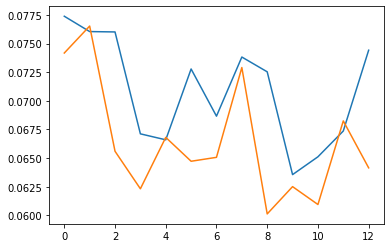

아_______________ᅡ___ᅡ___________ᅵ__아__아__아__아__이__아___________________________.<eos>
아ᅡᅡᅵ아아아아이아.<eos>
이런, 우리 문이 열려 있어!<eos>_____


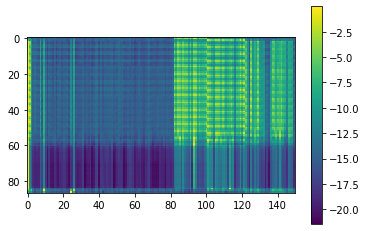

이_______________________ᅡ___ᅡ__아__아__아__아__아__아__아__아__아__아__아__아__아__이_ᆻᆻᄃᄃ___________________________________.<eos>
이ᅡᅡ아아아아아아아아아아아아아있ᄃ.<eos>
이십 년 전에는 피씨를 갖고 있는 사람이 많이 없었다.<eos>________


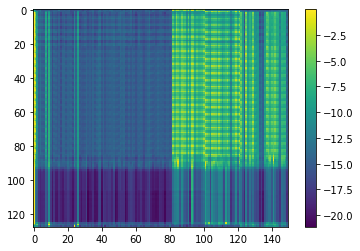

-------------------------------------------------------------------------------------------------------
09-19 00:18:45
Mean Train Loss: 0.07538648395720231
Mean Evaluation Loss: 0.07383685070796683
-------------------------------------------------------------------------------------------------------
09-19 00:18:59
Mean Train Loss: 0.07612539617910621
Mean Evaluation Loss: 0.07040046007510568
-------------------------------------------------------------------------------------------------------
09-19 00:19:13
Mean Train Loss: 0.07015125100039012
Mean Evaluation Loss: 0.06424450413924984
-------------------------------------------------------------------------------------------------------
09-19 00:19:28
Mean Train Loss: 0.070833630889559
Mean Evaluation Loss: 0.07317012073809369
-------------------------------------------------------------------------------------------------------
09-19 00:19:42
Mean Train Loss: 0.0752193375141378
Mean Evaluation Loss: 0.07318002292263005
-------------

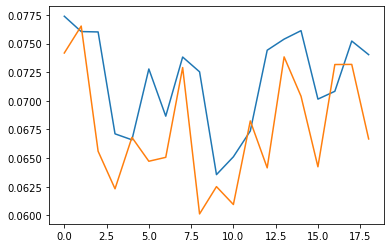

아____________________ 아 아 아_아_아____ ᄋ___ 아_ 아_ 이_ᅡᅡ_______________________________.<eos>
아 아 아 아아아 ᄋ 아 아 이ᅡ.<eos>
별것 아닌 일로 따지지 마라.<eos>____


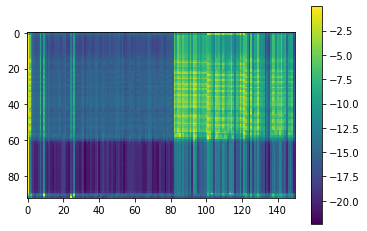

어_______________ 아 아_ 아_아_ 아_아_ 아 아 아_ 아ᅡ 아 았ᆻ다____________________________________________.<eos>
어 아 아 아아 아아 아 아 아 아 아 았다.<eos>
소문은 인터넷을 통해 순식간에 퍼졌다.<eos>


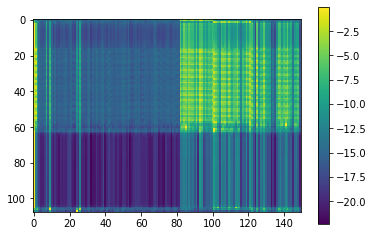

-------------------------------------------------------------------------------------------------------
09-19 00:20:11
Mean Train Loss: 0.06817999276553184
Mean Evaluation Loss: 0.06269190589323861
-------------------------------------------------------------------------------------------------------
09-19 00:20:25
Mean Train Loss: 0.06684814180643316
Mean Evaluation Loss: 0.062739060815652
-------------------------------------------------------------------------------------------------------
09-19 00:20:39
Mean Train Loss: 0.06667018624177655
Mean Evaluation Loss: 0.062440533485035324
-------------------------------------------------------------------------------------------------------
09-19 00:20:53
Mean Train Loss: 0.0660548186067497
Mean Evaluation Loss: 0.062471959296130704
-------------------------------------------------------------------------------------------------------
09-19 00:21:07
Mean Train Loss: 0.06827939931024972
Mean Evaluation Loss: 0.06130736901435483
-----------

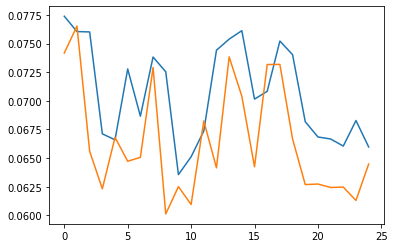

아______________으_____________ᅳ_____아_____________아________ᄋ______ᄋ___아_____아__ᄋ__아_____아_______아_아____다_____________________________________.<eos>
아으ᅳ아아ᄋᄋ아아ᄋ아아아아다.<eos>
미끄럼틀, 그네, 시소는 대체로 어린 아이들이 이용합니다.<eos>_________


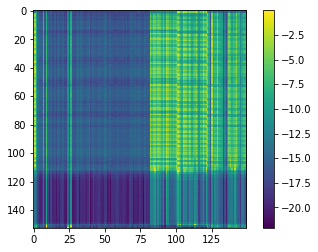

아______________ᅳ__아__아__ᅡ__아______아__아__ᅡ__아__아__ᅡ__아_아__ᅡ__아_아_ 아_아__아_이_다________________________________.<eos>
아ᅳ아아ᅡ아아아ᅡ아아ᅡ아아ᅡ아아 아아아이다.<eos>
성인이 되면 스스로의 행동에 대해 책임을 져야 합니다.<eos>__________


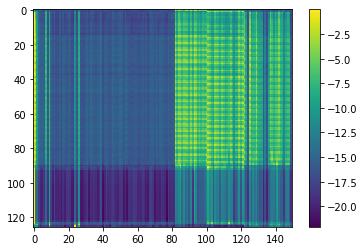

-------------------------------------------------------------------------------------------------------
09-19 00:21:36
Mean Train Loss: 0.07017458965901249
Mean Evaluation Loss: 0.06620523752059682
-------------------------------------------------------------------------------------------------------
09-19 00:21:50
Mean Train Loss: 0.06865349537085493
Mean Evaluation Loss: 0.07462152473425634
-------------------------------------------------------------------------------------------------------
09-19 00:22:03
Mean Train Loss: 0.0697936097965163
Mean Evaluation Loss: 0.062085937419256214
-------------------------------------------------------------------------------------------------------
09-19 00:22:18
Mean Train Loss: 0.06609374132791786
Mean Evaluation Loss: 0.058993876170632786
-------------------------------------------------------------------------------------------------------
09-19 00:22:32
Mean Train Loss: 0.06407605478709534
Mean Evaluation Loss: 0.06110622095884782
---------

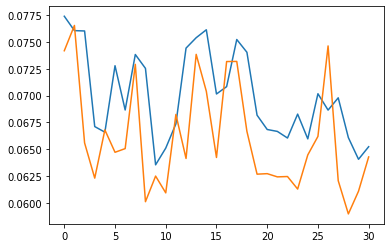

아_____________ᅡ__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__ᄃ__다______________________.<eos>
아ᅡ아아아아아아아아아아아아아아아아아아아아아아아ᄃ다.<eos>
그 코치는 선수들에게 가혹하게 대하는 걸로 악명 높았다.<eos>_______


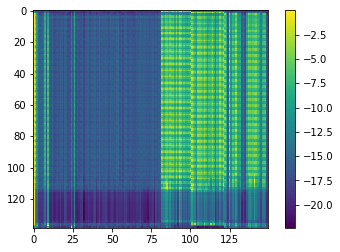

아______ᅳ__으__으__아__아__아__아__아__아__아__아__아__아_____ᄋ__아__아__아__아__아__어__ᄋᄋ__________________________________ᅭ.<eos>
아ᅳ으으아아아아아아아아아아ᄋ아아아아아어요.<eos>
모든 새가 날 수 있는 건 아니지만, 모든 새는 날개가 있어요.<eos>___


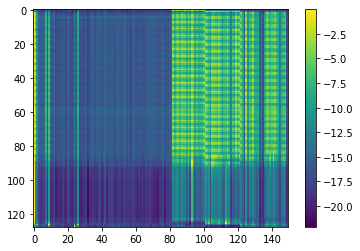

-------------------------------------------------------------------------------------------------------
09-19 00:23:01
Mean Train Loss: 0.0692075483484067
Mean Evaluation Loss: 0.06488888553037786
-------------------------------------------------------------------------------------------------------
09-19 00:23:15
Mean Train Loss: 0.06649018493042468
Mean Evaluation Loss: 0.06220752206564878
-------------------------------------------------------------------------------------------------------
09-19 00:23:30
Mean Train Loss: 0.06471809912034177
Mean Evaluation Loss: 0.05882432318091501
-------------------------------------------------------------------------------------------------------
09-19 00:23:43
Mean Train Loss: 0.06383285283061287
Mean Evaluation Loss: 0.05989098983917848
-------------------------------------------------------------------------------------------------------
09-19 00:23:58
Mean Train Loss: 0.0632758471465761
Mean Evaluation Loss: 0.060151212680366
--------------

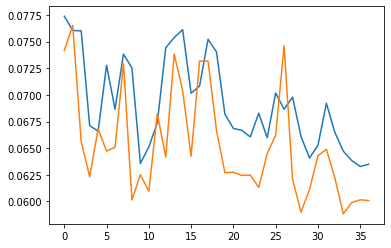

어___________ᅳ___으__으__으__으___아__아__아___ᅡ__아__아__으__아___아__닙_니__다____________________________________________.<eos>
어ᅳ으으으으아아아ᅡ아아으아아닙니다.<eos>
많은 사람들이 일자리를 찾아 대도시로 온다.<eos>_________


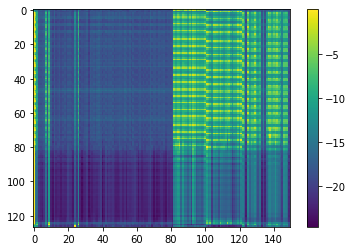

아______________ᅳ___아__아__아__아__아__이__니__다_____________________________________________.<eos>
아ᅳ아아아아아이니다.<eos>
담당자를 연결해 드리겠습니다.<eos>___________


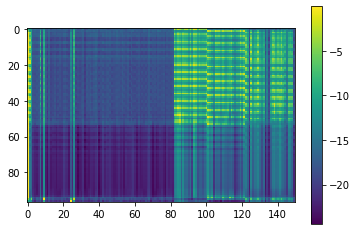

-------------------------------------------------------------------------------------------------------
09-19 00:24:26
Mean Train Loss: 0.06344604400117544
Mean Evaluation Loss: 0.05928191391782371
-------------------------------------------------------------------------------------------------------
09-19 00:24:40
Mean Train Loss: 0.06407426155581579
Mean Evaluation Loss: 0.060460072313248334
-------------------------------------------------------------------------------------------------------
09-19 00:24:54
Mean Train Loss: 0.06346829265153568
Mean Evaluation Loss: 0.060648238097086506
-------------------------------------------------------------------------------------------------------
09-19 00:25:08
Mean Train Loss: 0.06374199046610966
Mean Evaluation Loss: 0.0633991336495612
-------------------------------------------------------------------------------------------------------
09-19 00:25:22
Mean Train Loss: 0.06717298900619416
Mean Evaluation Loss: 0.06034489135399882
---------

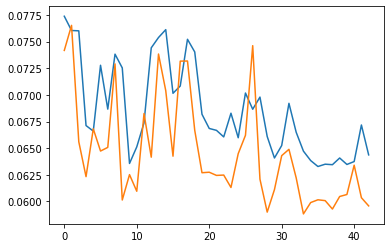

아_______________아__아__아__아__아__아__아___아__아__아__아___어_______________________ᅭ.<eos>
아아아아아아아아아아아아어ᅭ.<eos>
요즘에는 옛날이 몹시 그리워요.<eos>


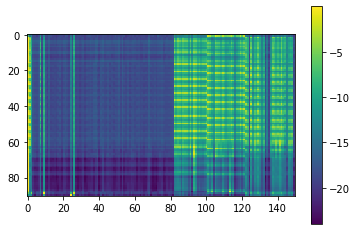

아________ᅳ__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__아__어__ᄋ_______________________________ᅭ.<eos>
아ᅳ아아아아아아아아아아아아아아아아아아아어요.<eos>
저는 눈빛만 봐도 아내가 무슨 생각을 하는지 알 수가 있어요.<eos>__


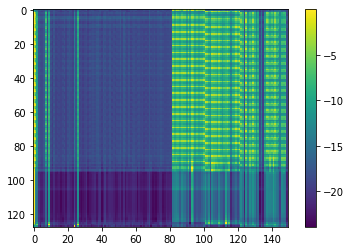

-------------------------------------------------------------------------------------------------------
09-19 00:25:50
Mean Train Loss: 0.06693328904650642
Mean Evaluation Loss: 0.07306975087100506
-------------------------------------------------------------------------------------------------------
09-19 00:26:04
Mean Train Loss: 0.06876671541341765
Mean Evaluation Loss: 0.059537790614129185
-------------------------------------------------------------------------------------------------------
09-19 00:26:18
Mean Train Loss: 0.06340852309770073
Mean Evaluation Loss: 0.05842859272520995
-------------------------------------------------------------------------------------------------------
09-19 00:26:32
Mean Train Loss: 0.06268239623198052
Mean Evaluation Loss: 0.0585757178868033
-------------------------------------------------------------------------------------------------------
09-19 00:26:47
Mean Train Loss: 0.06314784585137152
Mean Evaluation Loss: 0.05940924076080073
----------

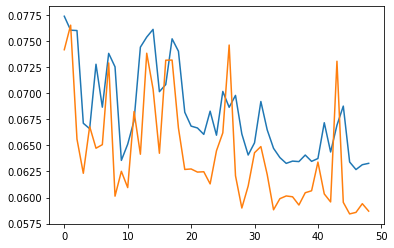

어_________________어__아__으__________아__아__아__아__아__아_어_어__어__아__아__아__어__어___________________________________ᅭ.<eos>
어어아으아아아아아아어어어아아아어어ᅭ.<eos>
부모님은 저에게 참되게 살라고 가르치셨어요.<eos>___________


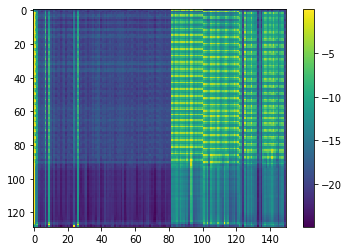

어___________________아__아_아__아__아__아__아__어__어__어__어__어__어__아__아__어__어__ᄋᄋ___________________________________ᅭ.<eos>
어아아아아아아아어어어어어어아아어어요.<eos>
언젠가 수첩에 그 사람 전화번호 적어 놓은 게 있을 거예요.<eos>____


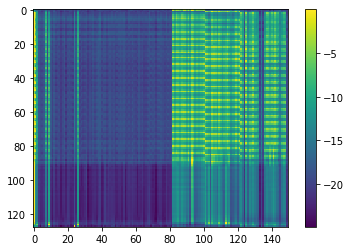

-------------------------------------------------------------------------------------------------------
09-19 00:27:16
Mean Train Loss: 0.062321495216698934
Mean Evaluation Loss: 0.05763658797279606
-------------------------------------------------------------------------------------------------------
09-19 00:27:30
Mean Train Loss: 0.061157549772375676
Mean Evaluation Loss: 0.058003485836453136
-------------------------------------------------------------------------------------------------------
09-19 00:27:44
Mean Train Loss: 0.06074701474755861
Mean Evaluation Loss: 0.05891540336965507
-------------------------------------------------------------------------------------------------------
09-19 00:27:58
Mean Train Loss: 0.06051194306836891
Mean Evaluation Loss: 0.058976387579749524
-------------------------------------------------------------------------------------------------------
09-19 00:28:12
Mean Train Loss: 0.060313113002741905
Mean Evaluation Loss: 0.05669960202435222
-----

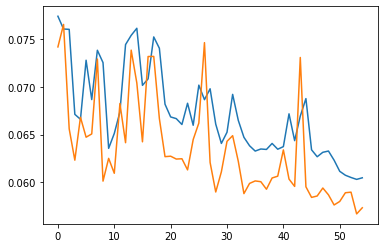

그_______으__이__이__이__으__이__으__으__________이__아__아___어__아__아__아__앴_다__다____________________________________________________________________________.<eos>
그으이이이으이으으이아아어아아아앴다다.<eos>
그녀는 육상 선수였기 때문에 굉장히 높이 뛸 수 있다.<eos>_________


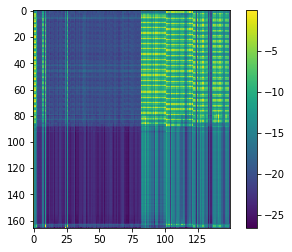

기_________________이__아__으__으______오__어__어__오__이__이__이__아__오__오__아__아__아__아__이__ᄋᄋᄋ_____________________ᅭ.<eos>
기이아으으오어어오이이이아오오아아아아이요.<eos>
이제부터는 어려운 부분만 집중적으로 공부할 필요가 있어요.<eos>___


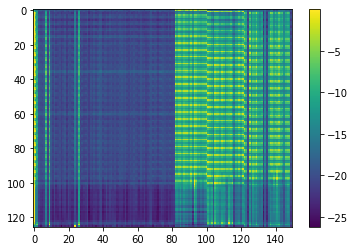

-------------------------------------------------------------------------------------------------------
09-19 00:28:41
Mean Train Loss: 0.062360111795012683
Mean Evaluation Loss: 0.0626257773843956
-------------------------------------------------------------------------------------------------------
09-19 00:28:55
Mean Train Loss: 0.0651252760224302
Mean Evaluation Loss: 0.06139133438673179
-------------------------------------------------------------------------------------------------------
09-19 00:29:09
Mean Train Loss: 0.06507843218435007
Mean Evaluation Loss: 0.061097075653642766
-------------------------------------------------------------------------------------------------------
09-19 00:29:23
Mean Train Loss: 0.06372861212900327
Mean Evaluation Loss: 0.05833232886269624
-------------------------------------------------------------------------------------------------------
09-19 00:29:38
Mean Train Loss: 0.06322476586781801
Mean Evaluation Loss: 0.05903769866553249
----------

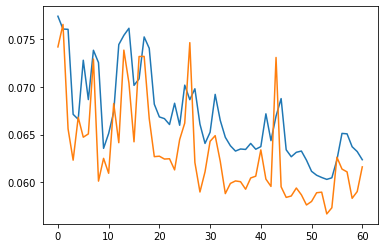

이__________ᅳ__아_________오__이___________________ᄋ_____________________________________.<eos>
이ᅳ아오이ᄋ.<eos>
이건 정말 기초적인 거야.<eos>______


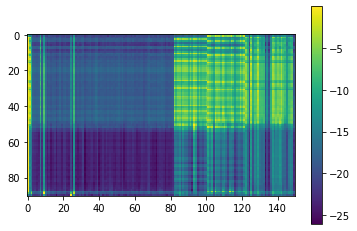

아_________이__이__아___ᅡ___ᅡ_______________________ᅩ__오_____ᄋᄋᄋ_____________________________________ᅭ.<eos>
아이이아ᅡᅡᅩ오요.<eos>
맥주 안주로 소시지만큼 좋은 게 없죠.<eos>____


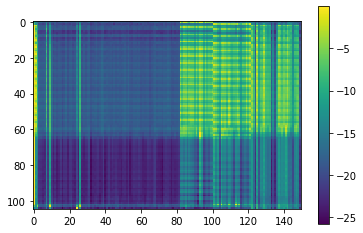

-------------------------------------------------------------------------------------------------------
09-19 00:30:07
Mean Train Loss: 0.06636071489308525
Mean Evaluation Loss: 0.06562830269493664
-------------------------------------------------------------------------------------------------------
09-19 00:30:21
Mean Train Loss: 0.0675667523866086
Mean Evaluation Loss: 0.06218475060561595
-------------------------------------------------------------------------------------------------------
09-19 00:30:35
Mean Train Loss: 0.06482440399462758
Mean Evaluation Loss: 0.060981593369895
-------------------------------------------------------------------------------------------------------
09-19 00:30:49
Mean Train Loss: 0.0645604616112134
Mean Evaluation Loss: 0.07314392954275924
-------------------------------------------------------------------------------------------------------
09-19 00:31:03
Mean Train Loss: 0.06679899876534896
Mean Evaluation Loss: 0.0586404329021464
---------------

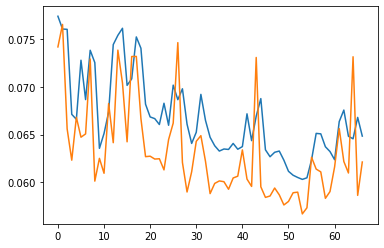

아__아_아__아__아__오___________아__아_ᆻ_다____________________________________________________________.<eos>
아아아아아오아았다.<eos>
우리는 도와 달라고 소리쳤다.<eos>____


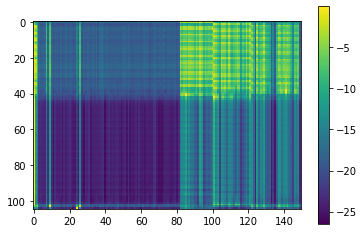

어_느__ᄋ__________아__아__아__아___ᅡ__아__아_______ᅡ__아__오_____아_아______________ᄋ__ᄋᄋᄋ___________________________________ᅭ.<eos>
어느ᄋ아아아아ᅡ아아ᅡ아오아아ᄋ요.<eos>
송편은 한국 사람들이 추석에 먹는 특별한 음식이에요.<eos>_____


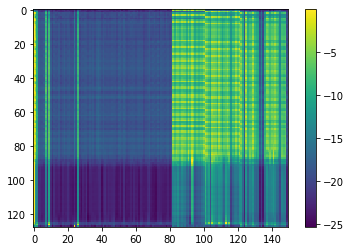

-------------------------------------------------------------------------------------------------------
09-19 00:31:31
Mean Train Loss: 0.06525203303240076
Mean Evaluation Loss: 0.06145861771874222
-------------------------------------------------------------------------------------------------------
09-19 00:31:45
Mean Train Loss: 0.06731695266813142
Mean Evaluation Loss: 0.06520696664350838
-------------------------------------------------------------------------------------------------------
09-19 00:31:59
Mean Train Loss: 0.0704036181476389
Mean Evaluation Loss: 0.06956540058059468
-------------------------------------------------------------------------------------------------------
09-19 00:32:13
Mean Train Loss: 0.06920313492099797
Mean Evaluation Loss: 0.05952313260820864
-------------------------------------------------------------------------------------------------------
09-19 00:32:27
Mean Train Loss: 0.06139269644030858
Mean Evaluation Loss: 0.05859004735654213
-----------

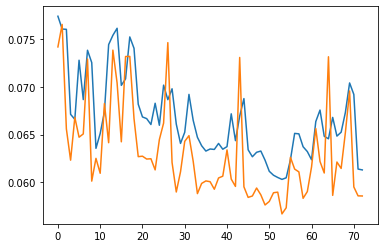

가______________ᅡ__아__아__아__아__아__어__아__이__니__다_______________________________________.<eos>
가ᅡ아아아아아어아이니다.<eos>
백 퍼센트 천연 과일 주스<eos>______


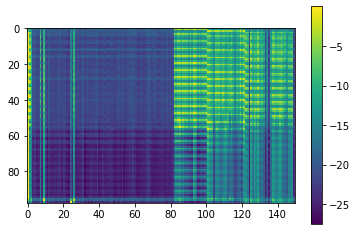

가_____________으__아__어______아__아__아__아__아__입_니__다___________________________________.<eos>
가으아어아아아아아입니다.<eos>
시장이 우리 학교를 방문했습니다.<eos>________


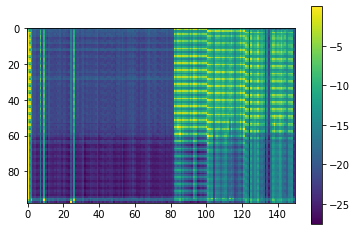

-------------------------------------------------------------------------------------------------------
09-19 00:32:56
Mean Train Loss: 0.06072243091302795
Mean Evaluation Loss: 0.05663397955476246
-------------------------------------------------------------------------------------------------------
09-19 00:33:10
Mean Train Loss: 0.06022857267140941
Mean Evaluation Loss: 0.059199211764206845
-------------------------------------------------------------------------------------------------------
09-19 00:33:24
Mean Train Loss: 0.059918608235464986
Mean Evaluation Loss: 0.057297007057499766
-------------------------------------------------------------------------------------------------------
09-19 00:33:38
Mean Train Loss: 0.060212070500617366
Mean Evaluation Loss: 0.058655032891266896
-------------------------------------------------------------------------------------------------------
09-19 00:33:53
Mean Train Loss: 0.05967574298405747
Mean Evaluation Loss: 0.055894784474772544
----

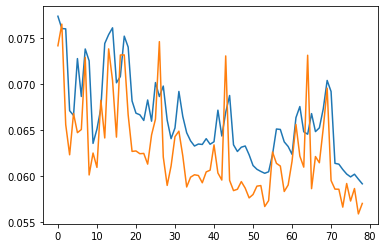

아_____________________아__아__아__아__아__아__아__에__ᄋ______________________________________________________________________________ᅭ.<eos>
아아아아아아아아에요.<eos>
진술하기 전에 선서하세요.<eos>______


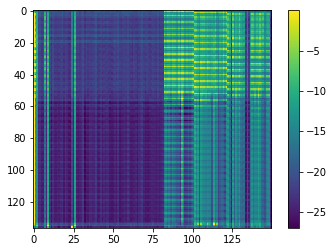

아_____________________아__으__아__으__아__아__으__오__ᄋ_______아__아__오__고__으__오__오__고__기__아__ᄋ_____________________ᅭ.<eos>
아아으아으아아으오ᄋ아아오고으오오고기아요.<eos>
그 사람은 아내와 헤어진 후 삶의 의욕을 잃어버린 것 같아요.<eos>___


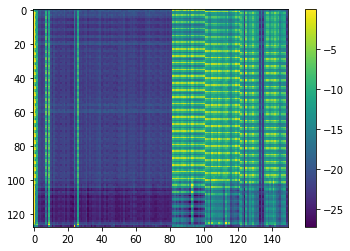

-------------------------------------------------------------------------------------------------------
09-19 00:34:22
Mean Train Loss: 0.05841751601837926
Mean Evaluation Loss: 0.05700138381530125
-------------------------------------------------------------------------------------------------------
09-19 00:34:36
Mean Train Loss: 0.05930420657634184
Mean Evaluation Loss: 0.0572987590054699
-------------------------------------------------------------------------------------------------------
09-19 00:34:51
Mean Train Loss: 0.05902344154688401
Mean Evaluation Loss: 0.0560017673964165
-------------------------------------------------------------------------------------------------------
09-19 00:35:05
Mean Train Loss: 0.05838630730906274
Mean Evaluation Loss: 0.05674668667514685
-------------------------------------------------------------------------------------------------------
09-19 00:35:20
Mean Train Loss: 0.057886318437788555
Mean Evaluation Loss: 0.05667372023003541
-----------

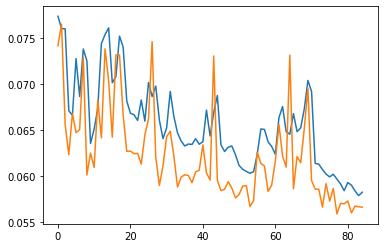

이_____________으__오__아__이__아__아__이__거__ᄋ________________________________________ᅭ.<eos>
이으오아이아아이거요.<eos>
노력한 보람이 있어서 기뻐요.<eos>___


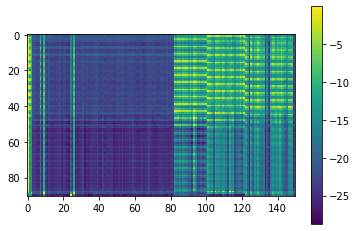

어_________________이__으__오__오__아__아__어__아__으__아__앴_다_________________________________________.<eos>
어이으오오아아어아으아앴다.<eos>
원숭이도 나무에서 떨어질 때가 있다.<eos>_______


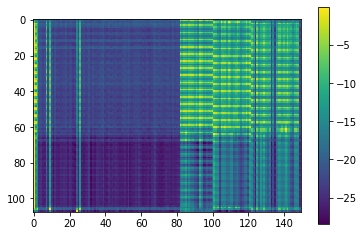

-------------------------------------------------------------------------------------------------------
09-19 00:35:49
Mean Train Loss: 0.057916073339333
Mean Evaluation Loss: 0.05493191076432445
-------------------------------------------------------------------------------------------------------
09-19 00:36:04
Mean Train Loss: 0.05729400647437872
Mean Evaluation Loss: 0.05459720602138269
-------------------------------------------------------------------------------------------------------
09-19 00:36:18
Mean Train Loss: 0.056407663016074194
Mean Evaluation Loss: 0.05450230503367017
-------------------------------------------------------------------------------------------------------
09-19 00:36:32
Mean Train Loss: 0.0568158594595895
Mean Evaluation Loss: 0.0545424392078121
-------------------------------------------------------------------------------------------------------
09-19 00:36:47
Mean Train Loss: 0.05646199323474296
Mean Evaluation Loss: 0.05259550925257561
-------------

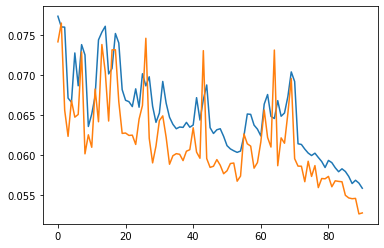

가_____________으__아__이__이__이__아_ 고__아____________________________________________________.<eos>
가으아이이이아 고아.<eos>
큰 트럭이 길을 막고 있다.<eos>____


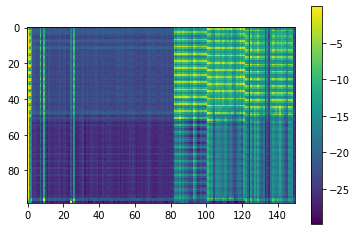

아_________아__아__아__아__으__으_ 아__아__아__아__아__지__아__이__이_ 다__가__다__다______________________________________.<eos>
아아아아아으으 아아아아아지아이이 다가다다.<eos>
한국에서는 아이들이 만으로 일곱 살에 학교에 입학한다.<eos>______


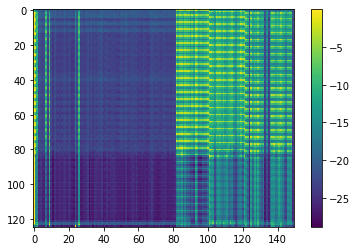

-------------------------------------------------------------------------------------------------------
09-19 00:37:15
Mean Train Loss: 0.054955001832814994
Mean Evaluation Loss: 0.05283372978071076
-------------------------------------------------------------------------------------------------------
09-19 00:37:29
Mean Train Loss: 0.055211041341077
Mean Evaluation Loss: 0.05262674972896349
-------------------------------------------------------------------------------------------------------
09-19 00:37:43
Mean Train Loss: 0.05465284268302315
Mean Evaluation Loss: 0.05121882013566892
-------------------------------------------------------------------------------------------------------
09-19 00:37:57
Mean Train Loss: 0.05399095360863771
Mean Evaluation Loss: 0.05113167396103304
-------------------------------------------------------------------------------------------------------
09-19 00:38:11
Mean Train Loss: 0.05320333764477602
Mean Evaluation Loss: 0.051497287660888416
----------

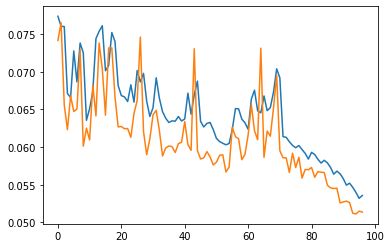

이_____________________이__으__고__이__이__으__으_ 바__가__아__아_ 나__있_어__ᄋ_________________________________ᅭ.<eos>
이이으고이이으으 바가아아 나있어요.<eos>
내일이 결혼 기념일이라는 걸 깜빡했어요.<eos>__________


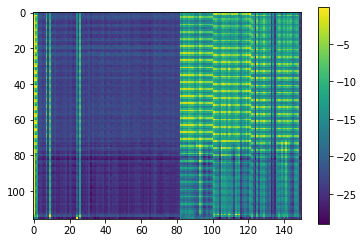

이_____________ᄉ___사__시__이__이__이_ 지_ 자__지__시__이__시__세__ᄋ________________________ᅭ.<eos>
이ᄉ사시이이이 지 자지시이시세요.<eos>
이 와이셔츠 내일까지 드라이 좀 해 주세요.<eos>____


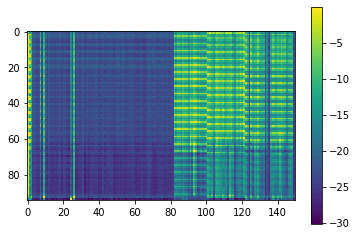

-------------------------------------------------------------------------------------------------------
09-19 00:38:40
Mean Train Loss: 0.05314359355626756
Mean Evaluation Loss: 0.04962504752580708
-------------------------------------------------------------------------------------------------------
09-19 00:38:54
Mean Train Loss: 0.05225897154970205
Mean Evaluation Loss: 0.049692256774954174
-------------------------------------------------------------------------------------------------------
09-19 00:39:08
Mean Train Loss: 0.05152916795200968
Mean Evaluation Loss: 0.050159615948142215
-------------------------------------------------------------------------------------------------------
09-19 00:39:22
Mean Train Loss: 0.05184718017754278
Mean Evaluation Loss: 0.05022887142961047
-------------------------------------------------------------------------------------------------------
09-19 00:39:36
Mean Train Loss: 0.051053136992450225
Mean Evaluation Loss: 0.048200945767143004
------

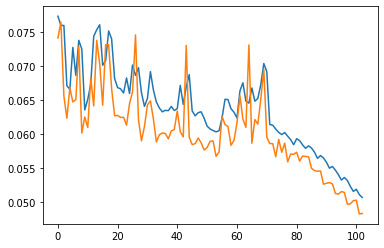

가_________________ᄉ___즈__이_ 저__저__으_ 자__아__에__ᄋ________________________________________________ᅭ.<eos>
가ᄉ즈이 저저으 자아에요.<eos>
다섯 명이서 조를 짜세요.<eos>________


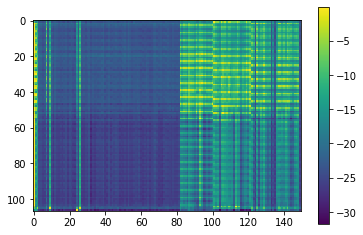

자__________ᅡ__으__지__즈__으__자__지__자__지__지__자_ 저__지__지__이__거__가__으_ 어__예__ᄋ_________________________________ᅭ.<eos>
자ᅡ으지즈으자지자지지자 저지지이거가으 어예요.<eos>
사람의 육체는 언젠가 죽지만, 정신은 영원한 거예요.<eos>________


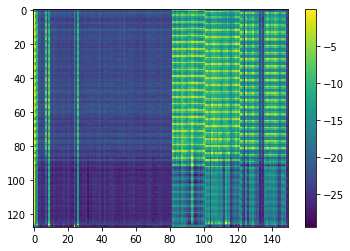

-------------------------------------------------------------------------------------------------------
09-19 00:40:05
Mean Train Loss: 0.049794392201126136
Mean Evaluation Loss: 0.04846014804777806
-------------------------------------------------------------------------------------------------------
09-19 00:40:19
Mean Train Loss: 0.05025250557660108
Mean Evaluation Loss: 0.048149646422713153
-------------------------------------------------------------------------------------------------------
09-19 00:40:33
Mean Train Loss: 0.04972877716257629
Mean Evaluation Loss: 0.04709437425349193
-------------------------------------------------------------------------------------------------------
09-19 00:40:47
Mean Train Loss: 0.04932467254121288
Mean Evaluation Loss: 0.04739017420682628
-------------------------------------------------------------------------------------------------------
09-19 00:41:01
Mean Train Loss: 0.048709594078529164
Mean Evaluation Loss: 0.04744464765844313
-------

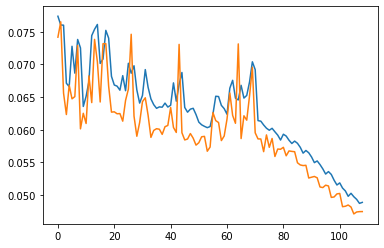

아_________아__으__시__지__으__은 자__으__드__르_ 가__고__시__시__이__아__ᄋ_______________________________________________________ᅭ.<eos>
아아으시지으은 자으드르 가고시시이아요.<eos>
만 원짜리 지폐를 잔돈으로 바꿀 수 있을까요?<eos>________


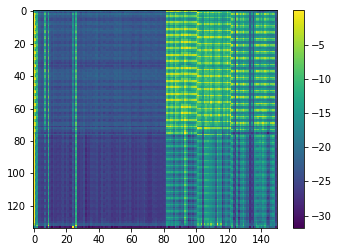

그_________사__으__은 나_______ᅵ__어__고__거__어__서___ᅵ__어__애__ᄋ__________________________ᅭ.<eos>
그사으은 나ᅵ어고거어서ᅵ어애요.<eos>
그 산길은 낮에도 어두워서 위험해요.<eos>_______


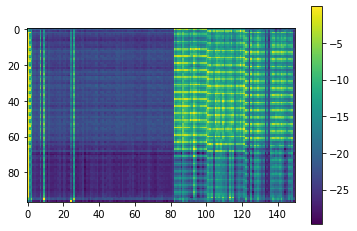

-------------------------------------------------------------------------------------------------------
09-19 00:41:30
Mean Train Loss: 0.048232116538097954
Mean Evaluation Loss: 0.04599177838768875
-------------------------------------------------------------------------------------------------------
09-19 00:41:44
Mean Train Loss: 0.04786721361876311
Mean Evaluation Loss: 0.04593665463425079
-------------------------------------------------------------------------------------------------------
09-19 00:41:58
Mean Train Loss: 0.04713600117018471
Mean Evaluation Loss: 0.04617918758838616
-------------------------------------------------------------------------------------------------------
09-19 00:42:13
Mean Train Loss: 0.047364162050071115
Mean Evaluation Loss: 0.04549985574656536
-------------------------------------------------------------------------------------------------------
09-19 00:42:27
Mean Train Loss: 0.04692364328079859
Mean Evaluation Loss: 0.04460063368706964
--------

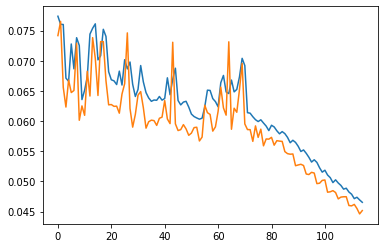

지_________________사__산_으_ 으__드__이__아_ 자__사__아__이_ 이__대__아_ 모_ 저__어__숬_습_니__다___________________________________________.<eos>
지사산으 으드이아 자사아이 이대아 모 저어숬습니다.<eos>
신입 사원 여러분들에 대한 사장님의 기대가 무척 크십니다.<eos>_____


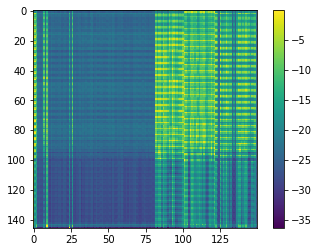

하_________고__자__안_는_는 애__이__이_ 고__오__으_ 오_ 고__조__이__있_습_니__다_______________________________________.<eos>
하고자안는는 애이이 고오으 오 고조이있습니다.<eos>
한국 사람들은 새해에 떡국을 먹는 풍습이 있습니다.<eos>________


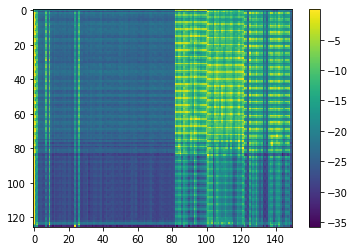

-------------------------------------------------------------------------------------------------------
09-19 00:42:55
Mean Train Loss: 0.04596353389784989
Mean Evaluation Loss: 0.044598581678177256
-------------------------------------------------------------------------------------------------------
09-19 00:43:09
Mean Train Loss: 0.046046017722731244
Mean Evaluation Loss: 0.04482558810303353
-------------------------------------------------------------------------------------------------------
09-19 00:43:23
Mean Train Loss: 0.04555450281264306
Mean Evaluation Loss: 0.04292255013158862
-------------------------------------------------------------------------------------------------------
09-19 00:43:37
Mean Train Loss: 0.045328325115913996
Mean Evaluation Loss: 0.04334523229533206
-------------------------------------------------------------------------------------------------------
09-19 00:43:51
Mean Train Loss: 0.044668852904728676
Mean Evaluation Loss: 0.043843577063333285
-----

In [22]:
batch_size = 16

num_thread = 3


EPOCH = 2 * 60 * 1

# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'nsml-test-with-kss'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")
    
# Load model if model weights already exists
try:
    load(net, 'model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list = batch
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list = batch
            pred_tensor_, loss = evaluate(net, ctc_loss, tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))

    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        # index is the position of the max probility of the first batch
        # Shape of the pred_tensor: (T, B, 75)
        # Shape of the index: (T)
        _, index = pred_tensor[:, 0, :].max(-1)

        # Change index numbers to character
        sentence = tokenizer.num2word(index.view(-1))
        
        # Change list to string
        print(''.join(sentence))
        
        # Remove "blank" and overlapping characters
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        # Plot image
        # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")
    
    
    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    np.save('model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)